In [1]:
import os
import glob
import datetime
import numpy as np
from astropy.io import fits
from photutils import DAOStarFinder, CircularAperture
import photutils.psf
import matplotlib.pyplot as plt
from astropy.visualization import LogStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from scipy.signal import peak_widths
import astropy.units as u
import pandas as pd
from scipy import stats
from calibFuncs import * #sortData, starLocate, nircEPSF, calcBinDist

In [2]:
datadir = 'C:\\Users\\willi\\Dropbox (Amherst College)\\Research\\Follette-Lab\\Thesis-Data\William\\trapezium_data\\nirc2-trapezium'
NIRC2_datasets = sortData(datadir, instrument='NIRC2', filesufx='*.fit*')

In [3]:
uniques = sortData(datadir, instrument='NIRC2', filesufx='*.fit*', returntab=True)

In [4]:
stacktest = 'C:\\Users\\willi\\Dropbox (Amherst College)\\Research\\Follette-Lab\\Thesis-Data\William\\trapezium_data\\nirc2-trapezium\\stacked\\theta1ori b_2001-12-20_NIRCshiftmed.fits'

Choose a reference star image to create a reference PSF from


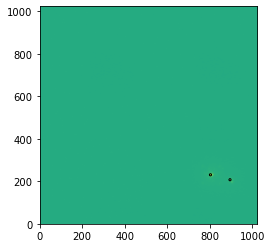

    xcentroid         ycentroid           roundness     
----------------- ------------------ -------------------
895.7540943433828 207.02645703238207 0.06888612477855645
803.6859095432949  230.3096867701864 0.07933102745959958
input the 0 indexed integer of your target from the table above: 1
target star is at  803 , 230  at FWHM 5.7135006295350195


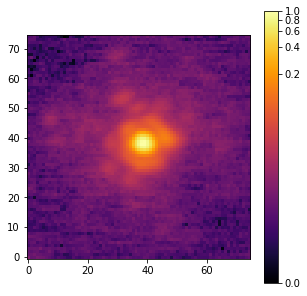

Select your target system to fit positions to


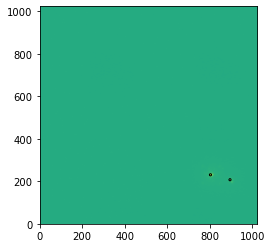

    xcentroid         ycentroid           roundness     
----------------- ------------------ -------------------
895.7540943433828 207.02645703238207 0.06888612477855645
803.6859095432949  230.3096867701864 0.07933102745959958
input the 0 indexed integer of your target from the table above: 0
target star is at  895 , 207  at FWHM 5.604529857896182
Stars found at positions
       x_0              y_0       
----------------- ----------------
38.62333926165128 37.9043197215002
       x_0               y_0       
----------------- -----------------
44.40336183952602 28.04324759189479

114.91700695999285 mas +/- 0.04864814433196933 mas
210.23915083588508 +/- 0.815677031005953
Choose a reference star image to create a reference PSF from


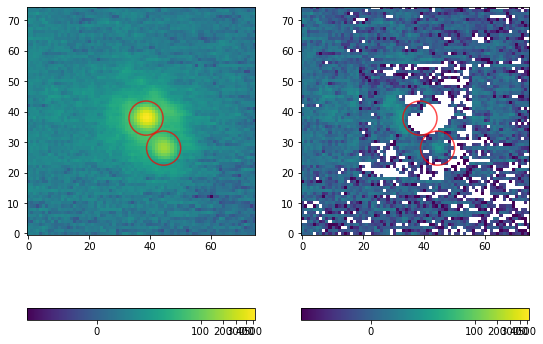

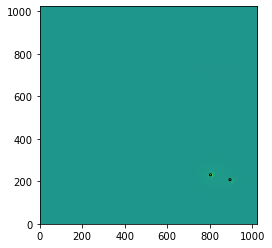

    xcentroid         ycentroid           roundness     
----------------- ------------------ -------------------
895.8930149371437  207.0534029075392 0.06544504854272098
803.8491155408852 230.30477749748977 0.07994032181042704


In [ ]:
data_frames = []
for dataset in NIRC2_datasets[0:1]:
    data = []
    for image in dataset:
        phot_results = NIRCLocate(image, 100, 5, 5, stampsize=75, epsfstamp=75, roundness=0.5, iterations=2, crit_sep=10, setfwhm=False)
        data.append(phot_results)
    data2 = np.asarray(data)
    data_frames.append(pd.DataFrame(data=data2, columns=['sep','seperr','PA','PAerr']))

In [6]:
data_frames

[          sep    seperr          PA     PAerr
 0  114.917007  0.048648  210.239151  0.815677
 1  115.573423  0.101478  210.310862  0.709624
 2  114.897162  0.167039  210.498029  1.115728
 3  114.734075  0.078875  210.155624  0.970630
 4  114.502952  0.044752  210.115379  0.977884
 5  114.773908  0.056464  210.294537  0.964059
 6  115.473504  0.081638  210.186644  0.726702]

In [7]:
data_frames[0].to_clipboard()

In [3]:
results = pd.read_csv('IRAFStarfind_B2-B3.csv', nrows=16)

In [4]:
results.columns

Index(['Date', 'Filter 1', 'Filter 2', 'Name', 'Sep B2-B3', 'Sep Error',
       'Good sep', 'Sep goodness', 'Conserv sep Error', 'Avg PA B2-B3',
       'Avg PA Error', 'Good Pa', 'PA Goodness', 'Conserv PA Error',
       'Num imgs used', 'True Sep B2-B3', 'True Sep Error', 'True PA',
       'True PA err', 'do not delete, vestigial (had to copy from pdf)'],
      dtype='object')

In [5]:
results = results.drop([5,7,10])

In [6]:
results['datetime'] = [datetime.datetime.strptime(x, '%Y-%m-%d') for x in results['Date']]
results['Epoch'] = [(x-results.datetime[0]).days for x in results.datetime]

In [7]:
from astropy.time import Time
results['MJD'] = [Time(x, format='datetime').mjd for x in results['datetime']]

In [8]:
np.zeros(len(results))+1

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [9]:
outtable = pd.DataFrame()
outtable['epoch'] = results['MJD']
outtable['object'] = np.zeros(len(results))+1
outtable['sep'] = results['Sep B2-B3']
outtable['sep_err'] = results['Sep Error']
outtable['pa'] = results['Avg PA B2-B3']
outtable['pa_err'] = results['Avg PA Error']
outtable.head()

,epoch,object,sep,sep_err,pa,pa_err
0,52263.0,1.0,114.980753,0.406738,210.256795,0.897230
1,53281.0,1.0,116.210375,0.300478,212.697247,-0.118090
2,53417.0,1.0,115.444214,0.343407,213.238768,0.542288
3,53426.0,1.0,114.995568,0.204996,212.981329,0.655344
4,55598.0,1.0,114.784870,0.204996,215.820127,1.643911


In [31]:
outtable.to_csv('B2-B3-orbitizetab.csv')

(-500.0, 6700.0)

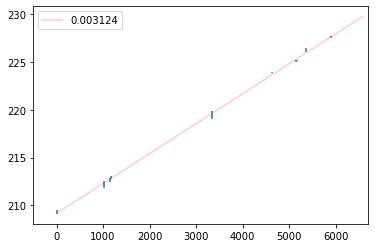

In [28]:
# DeRosa result
slope, intercept, r_value, p_value, std_err = stats.linregress(results['Epoch'][0:11], results['True PA'][0:11])
plt.errorbar(results['Epoch'], results['True PA'], yerr=results['True PA err'], ls='none')
plt.plot(results['Epoch'], intercept + slope*results['Epoch'], 'r', alpha=0.2, label=round(slope,6))
plt.legend()
plt.xlim(-500, 6700)

(-500.0, 6700.0)

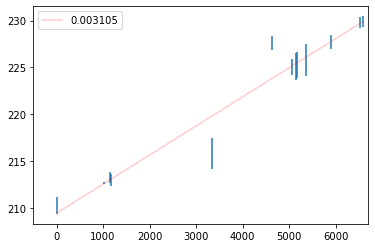

In [27]:
# my result
slope, intercept, r_value, p_value, std_err = stats.linregress(results['Epoch'], results['Avg PA B2-B3'])
plt.errorbar(results['Epoch'], results['Avg PA B2-B3'], yerr=results['Avg PA Error'], ls='none')
plt.plot(results['Epoch'], intercept + slope*results['Epoch'], 'r', alpha=0.2, label=round(slope,6))
plt.legend()
plt.xlim(-500, 6700)

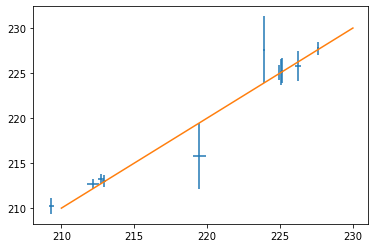

In [11]:
plt.errorbar(x=results['True PA'], y=results['Avg PA B2-B3'], xerr=results['True PA err'], yerr=results['Conserv PA Error'], ls='none')
plt.plot([210,230],[210,230])

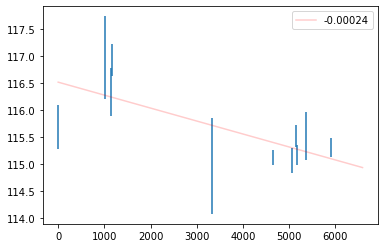

In [29]:
# DeRosa result for sep
slope, intercept, r_value, p_value, std_err = stats.linregress(results['Epoch'][0:11], results['True Sep B2-B3'][0:11])
plt.errorbar(results['Epoch'], results['True Sep B2-B3'], yerr=results['True Sep Error'], ls='none')
plt.plot(results['Epoch'], intercept + slope*results['Epoch'], 'r', alpha=0.2, label=round(slope,6))
plt.legend()
# plt.xlim(-500, 6700)

(-500.0, 6700.0)

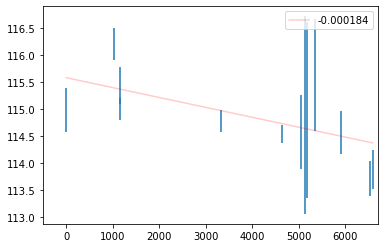

In [30]:
# my result
slope, intercept, r_value, p_value, std_err = stats.linregress(results['Epoch'], results['Sep B2-B3'])
plt.errorbar(results['Epoch'], results['Sep B2-B3'], yerr=results['Sep Error'], ls='none')
plt.plot(results['Epoch'], intercept + slope*results['Epoch'], 'r', alpha=0.2, label=round(slope,6))
plt.legend()
plt.xlim(-500, 6700)